# Mandatory Assignment 4

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy.stats import zscore

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

## Load and explore the data

In [68]:
galaxy_df = pd.read_csv('assets/train.csv')
galaxy_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [69]:
galaxy_df.isna().sum()

obj_ID           0
alpha            0
delta            0
u              362
g                0
r                0
i                0
z                0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID      0
class            0
redshift         0
plate            0
MJD              0
fiber_ID         0
dtype: int64

### Pipeline to avoid repetive code (Pipeline 1)

### Defining the functions used in pipeline

In [70]:
class PCAZscoreOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, threshold=3):
        self.n_components = n_components
        self.threshold = threshold
    def fit(self, X, y=None):
        self.scaler_ = StandardScaler()
        X_scaled = self.scaler_.fit_transform(X)
        self.pca_ = PCA(n_components=self.n_components)
        X_pca = self.pca_.fit_transform(X_scaled)
        self.pc_means_ = np.mean(X_pca, axis=0)
        self.pc_stds_ = np.std(X_pca, axis=0)
        return self
    def transform(self, X, y=None):
        df = X.copy()
        X_scaled = self.scaler_.transform(df)
        X_pca = self.pca_.transform(X_scaled)
        z = np.abs((X_pca - self.pc_means_) / self.pc_stds_)
        mask = (z < self.threshold).all(axis=1)
        return df[mask]

def add_features(df):
    df = df.copy()
    df['feature1'] = df['redshift'] ** 2
    return df

def conditional_onehot(df):
    df = df.copy()
    if 'class' in df.columns:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        onehot = encoder.fit_transform(df[['class']])
        new_columns = encoder.get_feature_names_out(['class'])
        onehot_df = pd.DataFrame(onehot, columns=new_columns, index=df.index)
        df = df.drop(columns=['class'])
        df = pd.concat([onehot_df, df], axis=1)
    return df

def drop_missing(df):
    return df.dropna()

## Pipeline 1

In [73]:
X = galaxy_df.drop(columns=["class"])
y = galaxy_df["class"]

# Build the feature engineering pipeline using your new outlier remover.
feature_pipeline = Pipeline([
    ("add_features", FunctionTransformer(add_features, validate=False)),
    ("conditional_onehot", FunctionTransformer(conditional_onehot, validate=False)),
    ("drop_missing", FunctionTransformer(drop_missing, validate=False)),
    ("pca_outlier_removal", PCAZscoreOutlierRemover(n_components=2, threshold=3))
])

# Transform features and update y to match the filtered indices.
X_transformed = feature_pipeline.fit_transform(X)
y_transformed = y.loc[X_transformed.index]

# Identify categorical and numerical columns.
cat_cols = [col for col in X_transformed.columns if X_transformed[col].dtype == "object"]
num_cols = [col for col in X_transformed.columns if col not in cat_cols]

# Build the preprocessor.
preprocessor = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols)
])

# Build the RandomForest pipeline.
pipeline_rf = Pipeline([
    ("pre", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Define a grid search parameter grid.
param_grid = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None]
}

grid_search = GridSearchCV(pipeline_rf, param_grid=param_grid, scoring="f1_macro", cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_transformed, y_transformed)

print("Best parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

CV Score: 0.9750432325869787 , Std = 0.0005172944870882063


## Pipeline 2

In [74]:
X_raw = galaxy_df.drop(columns=["class"])
y_raw = galaxy_df["class"]

# Build the feature pipeline (including your new PCA-zscore outlier remover).
feature_pipeline = Pipeline([
    ('add_features', FunctionTransformer(add_features, validate=False)),
    ('conditional_onehot', FunctionTransformer(conditional_onehot, validate=False)),
    ('drop_missing', FunctionTransformer(drop_missing, validate=False)),
    ('pca_outlier_removal', PCAZscoreOutlierRemover(n_components=2, threshold=3))
])

# Transform X and update y accordingly.
X_fe = feature_pipeline.fit_transform(X_raw)
y_fe = y_raw.loc[X_fe.index]

# Determine categorical and numerical columns.
cat_cols = [col for col in X_fe.columns if X_fe[col].dtype == "object"]
num_cols = [col for col in X_fe.columns if col not in cat_cols]

# Build the preprocessor.
preprocessor = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols)
])

# Build the full pipeline with LogisticRegression (which uses L2 regularization by default).
pipeline_full = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42))
])

# Define grid for the regularization strength parameter, C.
param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Perform grid search.
grid_search = GridSearchCV(pipeline_full, param_grid, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_fe, y_fe)

print("Best parameters:", grid_search.best_params_)
print("LogReg CV Score:", grid_search.best_score_)

Best parameters: {'classifier__C': 100.0}
LogReg CV Score: 0.956976938481137


### Correlation matrix to check what columns should be dropper/tuned

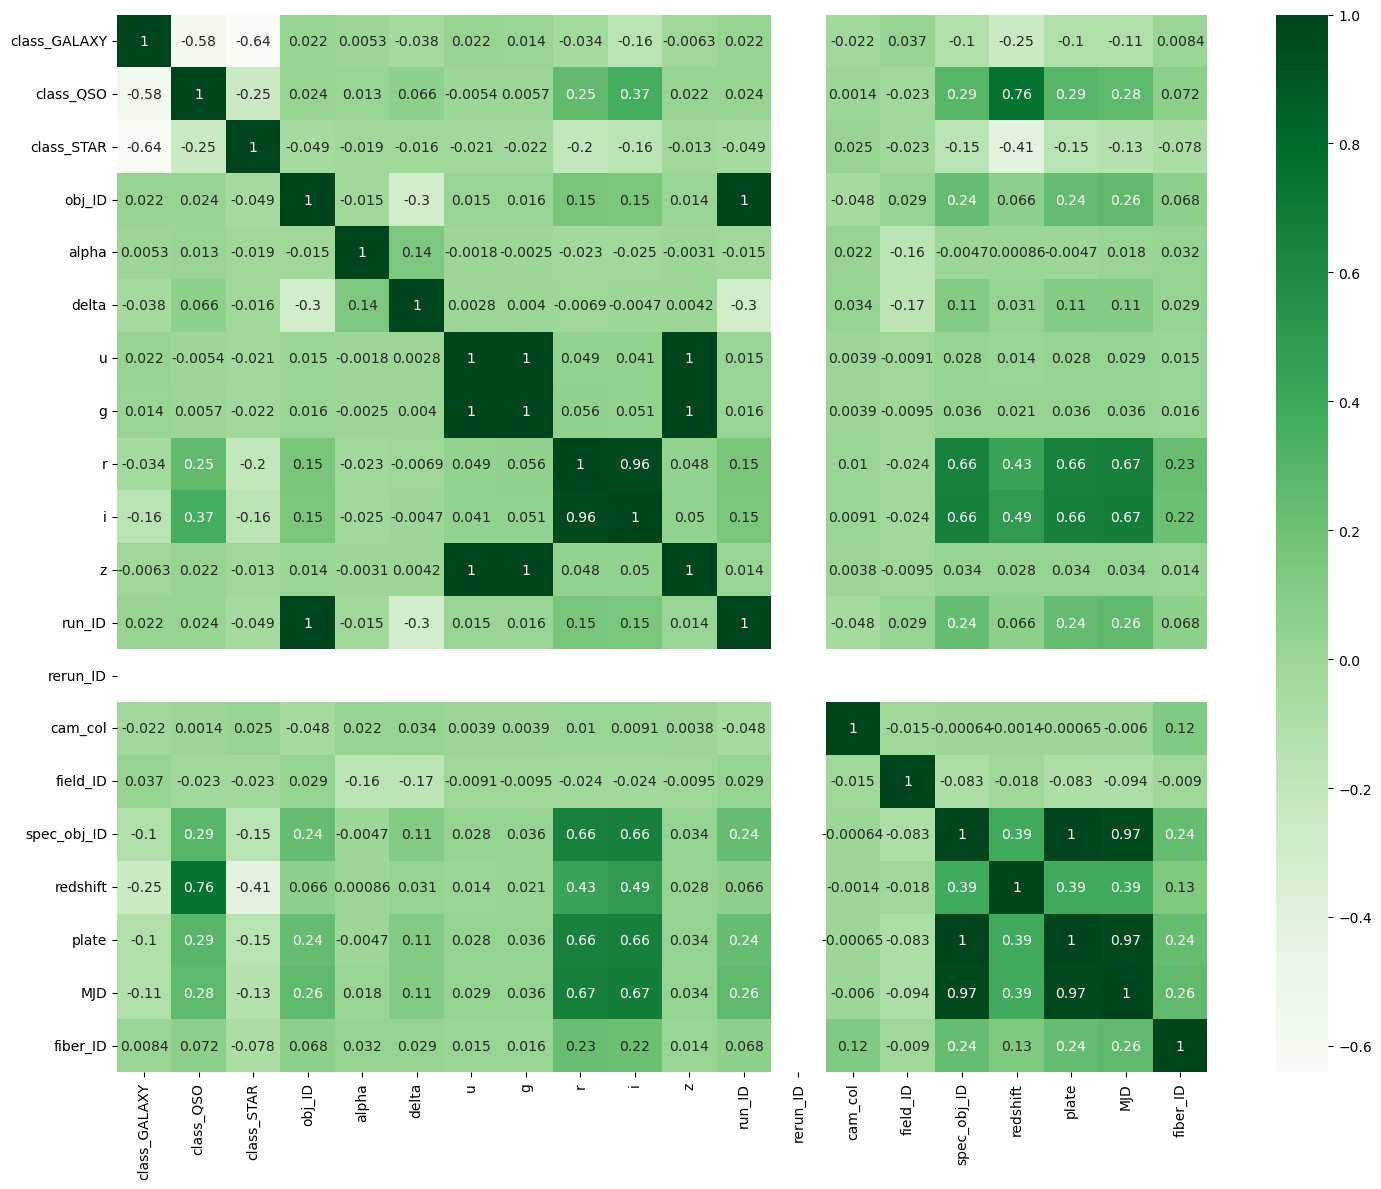

In [ ]:
# Correlation matrix
matrix = processed_galaxy_df_1.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(matrix, cmap="Greens", annot=True)
plt.tight_layout()
plt.show()

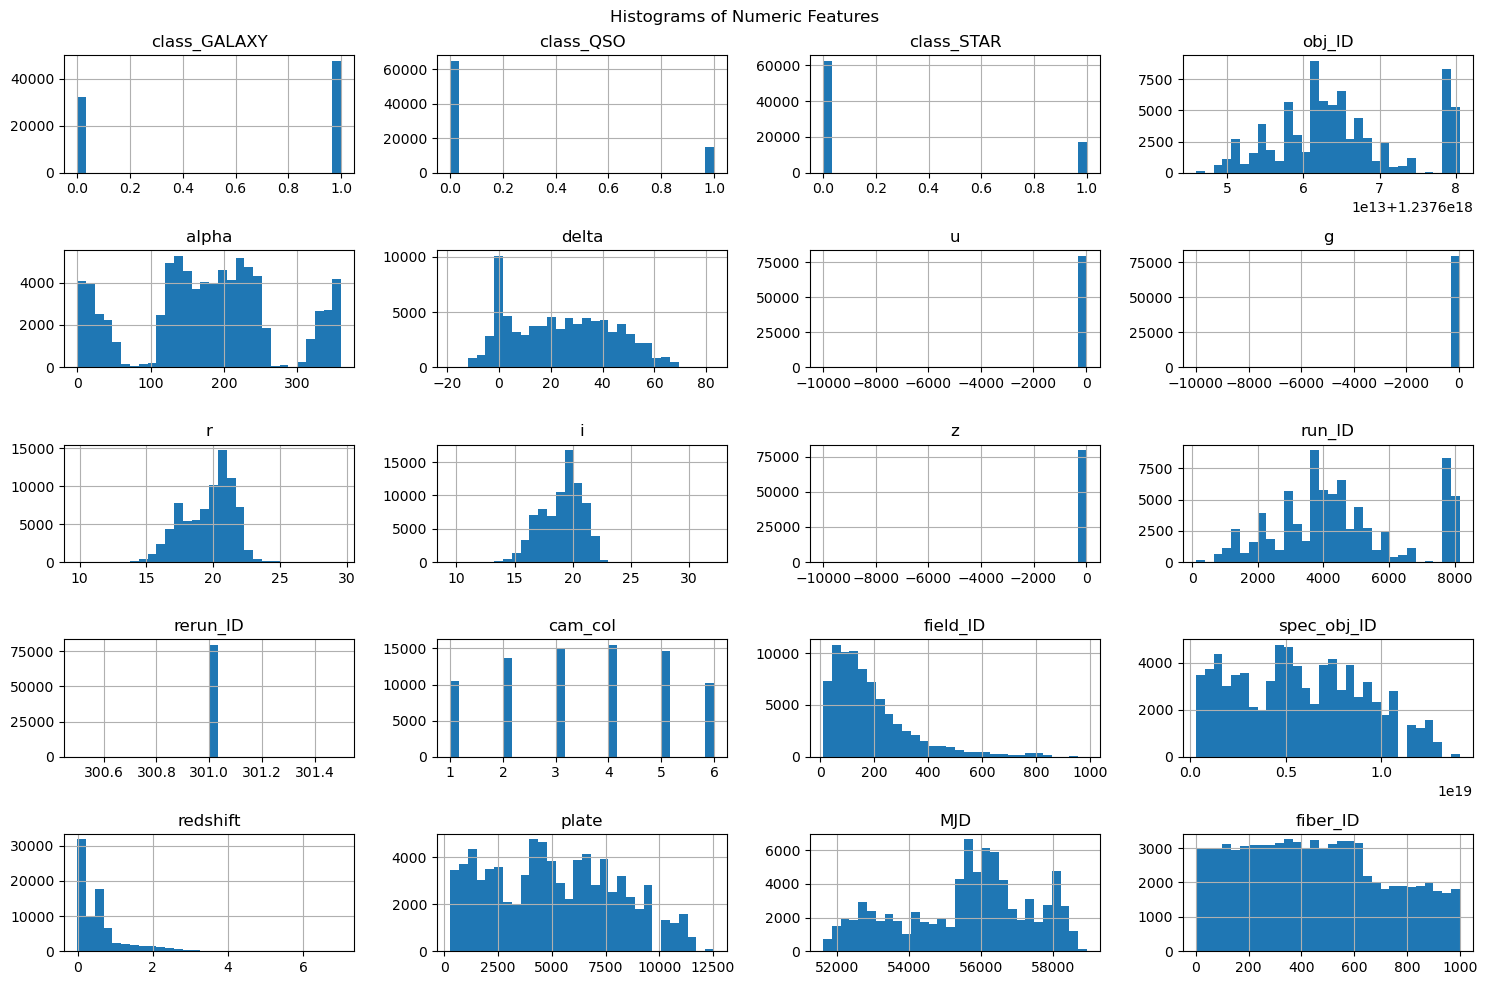

In [ ]:
numeric_cols = processed_galaxy_df_1.select_dtypes(include=["number"]).columns
processed_galaxy_df_1[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Features")
plt.tight_layout()
plt.show()

# Choosing models

In [ ]:


param_grid = {
    'clf__C': [0.1, 1, 5, 10],
    'clf__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'clf__kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(pipeline_full, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X, y)
print("Beste parametere: ", grid_search.best_params_)

NameError: name 'pipeline_full' is not defined